# MobileNetV3Small

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.metrics import classification_report, confusion_matrix


DATA_ROOT = "DatasetB_split"   
IMG_SIZE = (224, 224)
BATCH_SIZE = 8               
EPOCHS = 45
SEED = 42



train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

# extract class names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)



data_aug = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.35),
    layers.RandomZoom(0.35),
    layers.RandomContrast(0.25),
    layers.RandomBrightness(0.25),
], name="data_augmentation")


base = MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,),
    dropout_rate=0.2
)

base.trainable = False  # freeze for Phase 1

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_aug(inputs)  # augmentation
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)



history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)



base.trainable = True  

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + 15,
    initial_epoch=history.epoch[-1]
)

loss, acc = model.evaluate(test_ds)
print(f"\n⭐ TEST ACCURACY: {acc:.4f}")

# detailed predictions
y_true = []
y_pred = []

for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))



os.makedirs("exports", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # int8
tflite_model = converter.convert()

with open("exports/mobilenetv3small_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("\nSaved TFLite model: mobilenetv3small_int8.tflite")


Found 76 files belonging to 3 classes.
Found 25 files belonging to 3 classes.
Found 26 files belonging to 3 classes.
Classes: ['Diseased', 'Healthy', 'Pests']
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                  

Epoch 1/45
10/10 [==============================] - 2s 81ms/step - loss: 1.3181 - accuracy: 0.3553 - val_loss: 1.1979 - val_accuracy: 0.2800
Epoch 2/45
10/10 [==============================] - 0s 35ms/step - loss: 1.2625 - accuracy: 0.3553 - val_loss: 1.1915 - val_accuracy: 0.2400
Epoch 3/45
10/10 [==============================] - 0s 35ms/step - loss: 1.1685 - accuracy: 0.4079 - val_loss: 1.1912 - val_accuracy: 0.2400
Epoch 4/45
10/10 [==============================] - 0s 35ms/step - loss: 1.3431 - accuracy: 0.3553 - val_loss: 1.1882 - val_accuracy: 0.2400
Epoch 5/45
10/10 [==============================] - 0s 36ms/step - loss: 1.2891 - accuracy: 0.3421 - val_loss: 1.1872 - val_accuracy: 0.2400
Epoch 6/45
10/10 [==============================] - 0s 35ms/step - loss: 1.2557 - accuracy: 0.3816 - val_loss: 1.1842 - val_accuracy: 0.2400
Epoch 7/45
10/10 [==============================] - 0s 35ms/step - loss: 1.2237 - accuracy: 0.4079 - val_loss: 1.1813 - val_accuracy: 0.2400
Epoch 8/45
10

Epoch 45/60
10/10 [==============================] - 6s 123ms/step - loss: 1.1898 - accuracy: 0.4474 - val_loss: 1.1432 - val_accuracy: 0.3200
Epoch 46/60
10/10 [==============================] - 1s 75ms/step - loss: 1.2138 - accuracy: 0.3947 - val_loss: 1.1391 - val_accuracy: 0.3600
Epoch 47/60
10/10 [==============================] - 1s 74ms/step - loss: 1.2500 - accuracy: 0.4211 - val_loss: 1.1312 - val_accuracy: 0.4000
Epoch 48/60
10/10 [==============================] - 1s 74ms/step - loss: 1.2000 - accuracy: 0.4342 - val_loss: 1.1282 - val_accuracy: 0.4000
Epoch 49/60
10/10 [==============================] - 1s 77ms/step - loss: 1.1104 - accuracy: 0.4474 - val_loss: 1.1279 - val_accuracy: 0.4000
Epoch 50/60
10/10 [==============================] - 1s 76ms/step - loss: 1.0794 - accuracy: 0.4868 - val_loss: 1.1271 - val_accuracy: 0.4400
Epoch 51/60
10/10 [==============================] - 1s 75ms/step - loss: 1.0888 - accuracy: 0.4474 - val_loss: 1.1311 - val_accuracy: 0.4400
Epoch

INFO:tensorflow:Assets written to: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmp7_778ing/assets



Saved TFLite model: mobilenetv3small_int8.tflite


2025-11-13 18:45:42.494285: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-11-13 18:45:42.494310: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-11-13 18:45:42.494931: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmp7_778ing
2025-11-13 18:45:42.511957: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-11-13 18:45:42.511974: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmp7_778ing
2025-11-13 18:45:42.543661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-11-13 18:45:42.556172: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-11-13 18:45:43.035465: I tensorflow/cc/saved_model/loader.

# EfficientNetV2-S

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2S
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import legacy as legacy_optimizers



DATA_ROOT = "DatasetB_split"
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 60
SEED = 42


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)



data_aug = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.35),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.GaussianNoise(0.05),
])



base = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    include_preprocessing=True,
    input_shape=IMG_SIZE + (3,),
)

base.trainable = False  # phase 1

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_aug(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=legacy_optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


print("\n=== TRAINING PHASE 1 (Frozen Backbone) ===")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)


fine_tune_at = int(len(base.layers) * 0.7)

for layer in base.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=legacy_optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

print(f"\n=== FINE-TUNING from layer {fine_tune_at}/{len(base.layers)} ===")
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + 20,
    initial_epoch=history.epoch[-1] + 1
)


loss, acc = model.evaluate(test_ds)
print(f"\n⭐ EfficientNetV2-S TEST ACCURACY: {acc:.4f}")

y_true = []
y_pred = []

for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))



os.makedirs("exports", exist_ok=True)

# Float model
conv = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float = conv.convert()
open("exports/efficientnet_v2s_float32.tflite", "wb").write(tflite_float)

# INT8 optimized
conv = tf.lite.TFLiteConverter.from_keras_model(model)
conv.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_int8 = conv.convert()
open("exports/efficientnet_v2s_int8.tflite", "wb").write(tflite_int8)

print("\nSaved EfficientNetV2-S TFLite models!")


Found 76 files belonging to 3 classes.
Found 25 files belonging to 3 classes.
Found 26 files belonging to 3 classes.
Classes: ['Diseased', 'Healthy', 'Pests']
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (No

INFO:tensorflow:Assets written to: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmpyumo4c6p/assets
2025-11-13 19:03:36.910042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-11-13 19:03:36.910364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-11-13 19:03:36.910859: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmpyumo4c6p
2025-11-13 19:03:36.964337: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-11-13 19:03:36.964356: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmpyumo4c6p
2025-11-13 19:03:37.089419: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-11-13 19:03:37.933435: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

INFO:tensorflow:Assets written to: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmpfhean6db/assets


INFO:tensorflow:Assets written to: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmpfhean6db/assets
2025-11-13 19:04:18.953634: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-11-13 19:04:18.953671: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-11-13 19:04:18.953911: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmpfhean6db
2025-11-13 19:04:19.013179: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-11-13 19:04:19.013208: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/lq/90xs6mj17d73071t7twq5nmr0000gn/T/tmpfhean6db
2025-11-13 19:04:19.150217: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-11-13 19:04:20.006741: I tensorflow/cc/saved_model/loader.cc:217] Running initialization


Saved EfficientNetV2-S TFLite models!


# BINARY DATA

Model loaded!


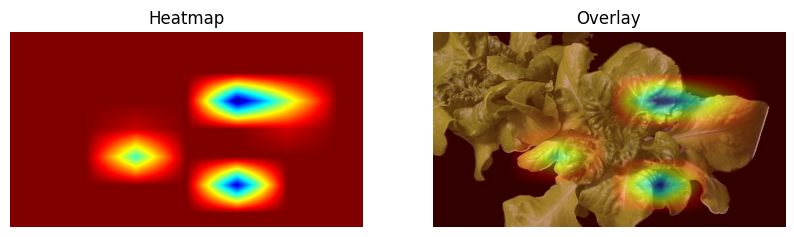

🔥 Grad-CAM saved as cam_heatmap.png and cam_overlay.png


In [ ]:
import torch
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt


model_path = "/Users/leighchejaikarran/runs/classify/binary_final/weights/best.pt"
model = YOLO(model_path)
print("Model loaded!")

img_path = "test_image.png"    
orig = cv2.imread(img_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
img = cv2.resize(orig, (224, 224))

img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()
img_tensor /= 255.0

net = model.model


target_layer = None
for m in reversed(list(net.modules())):
    if isinstance(m, torch.nn.Conv2d):
        target_layer = m
        break


gradients = []
activations = []

def save_gradient(grad):
    gradients.append(grad)

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    save_gradient(grad_output[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


img_tensor.requires_grad = True
outputs = net(img_tensor)

# Predicted class index
outputs = net(img_tensor)[0]   # take first element of tuple → logits tensor
pred_class = outputs.argmax().item()


net.zero_grad()
one_hot = torch.zeros((1, outputs.shape[-1]))
one_hot[0][pred_class] = 1
outputs.backward(gradient=one_hot)

grads = gradients[-1].detach().numpy()[0]
acts = activations[-1].detach().numpy()[0]

weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (orig.shape[1], orig.shape[0]))
cam -= cam.min()
cam /= cam.max()

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = (heatmap * 0.4 + orig * 0.6).astype(np.uint8)


cv2.imwrite("cam_heatmap.png", cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))
cv2.imwrite("cam_overlay.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Heatmap")
plt.imshow(heatmap)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis('off')

plt.show()

print("🔥 Grad-CAM saved as cam_heatmap.png and cam_overlay.png")


In [6]:
import os
from ultralytics import YOLO
import tensorflow as tf

root = "/Users/leighchejaikarran/Downloads/frassmodel"

print("=== Checking YOLO models (.pt) ===")
for file in os.listdir(root):
    if file.endswith(".pt"):
        path = os.path.join(root, file)
        print("\nTesting:", path)
        try:
            model = YOLO(path)
            metrics = model.val(data="/Users/leighchejaikarran/Downloads/frassmodel/dataset.yaml")
            print("Top-1 Accuracy:", metrics.top1)
        except Exception as e:
            print("Failed:", e)

print("\n=== Checking Keras/TensorFlow models (.h5) ===")
for file in os.listdir(root):
    if file.endswith(".h5"):
        path = os.path.join(root, file)
        print("\nTesting:", path)
        try:
            model = tf.keras.models.load_model(path)
            print("Model loaded successfully: MAY BE THE HIGH ONE")
        except Exception as e:
            print("Failed to load:", e)


=== Checking YOLO models (.pt) ===

Testing: /Users/leighchejaikarran/Downloads/frassmodel/yolov8n-cls.pt
Ultralytics 8.3.228 🚀 Python-3.9.12 torch-2.8.0 CPU (Apple M1 Pro)
YOLOv8n-cls summary (fused): 30 layers, 2,715,880 parameters, 0 gradients, 4.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 156.9±104.9 MB/s, size: 31.8 KB)
val: Scanning /Users/leighchejaikarran/Downloads/frassmodel/DatasetBinary_split/val... 19 images, 0 corrupt: 100% ━━━━━━━━━━━━ 19/19 67.7Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 2/2 5.5it/s 0.4s1.0s
                   all          0          0
Speed: 0.0ms preprocess, 12.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /Users/leighchejaikarran/runs/classify/val9
Top-1 Accuracy: 0.0

Testing: /Users/leighchejaikarran/Downloads/frassmodel/yolov8n.pt
Ultralytics 8.3.228 🚀 Python-3.9.12 torch-2.8.0 CPU (Apple M1 Pro)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


/Users/leighchejaikarran/.pyenv/versions/3.9.12/lib/python3.9/site-packages/ultralytics/utils/metrics.py:650: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/Users/leighchejaikarran/.pyenv/versions/3.9.12/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/leighchejaikarran/.pyenv/versions/3.9.12/lib/python3.9/site-packages/ultralytics/utils/metrics.py:694: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/Users/leighchejaikarran/.pyenv/versions/3.9.12/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/leighchejaikarran/.pyenv/versions/3.9.12/lib/python3.9/site-packages/ultralytics/utils/metrics.py:694: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/Users/leighch

                   all         19          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 1.2ms preprocess, 168.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /Users/leighchejaikarran/runs/detect/val
Failed: 'DetMetrics' object has no attribute 'top1'. See valid attributes below.
Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes,
            target classes, and target image